In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
def rgb2gray(rgb):
    # Sets each pixel to a weighted value
    for x, row in enumerate(rgb):
        for y, col in enumerate(row):
            color = 0.2126 * rgb[x][y][0] + 0.7152 * rgb[x][y][1] + 0.0722 * rgb[x][y][2]
            rgb[x][y][0] = color

    return rgb

In [3]:
# Mask is a zero matrix
# fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
def fillMask(mask):
    h, w = mask.shape
    bottom_left = (h, 0)
    middle = (int(h/2), int(w/2))
    bottom_right = (h, w)
    
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            # Applying equations to left_bound and right_bound
            left_bound = (h - x) * middle[1] / middle[0]
            right_bound = x * middle[1] / middle[0]
            if y > left_bound and y < right_bound and x <= 400:
                mask[x][y] = 255
                
    return mask

In [4]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y] != 255:
                image[x][y] = 0
    return image

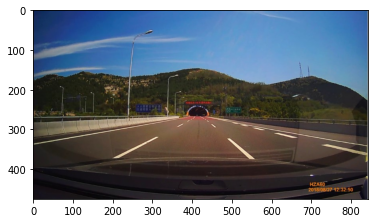

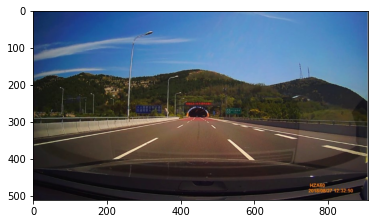

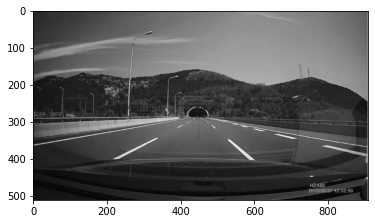

In [5]:
# Manual version takes a long time
# Read image from JPEG file
# Convert to grayscale
pil_im = Image.open("lane_sample1.jpeg")
orig = np.array(pil_im)
plt.imshow(orig)
plt.show()

# Resize so that standard height is 512
width = int(pil_im.width * 512 / pil_im.height)
pil_im = pil_im.resize((width , 512))

# Convert to np array
orig_img = np.array(pil_im)
plt.imshow(orig_img)
plt.show()

#Convert to grayscale
im = rgb2gray(orig_img)

# Deletes the 1 and 2 indices from the rgb parameter so the array can be squeezed
im = np.delete(im, [1, 2], 2)

plt.imshow(im, cmap='gray')
plt.show()

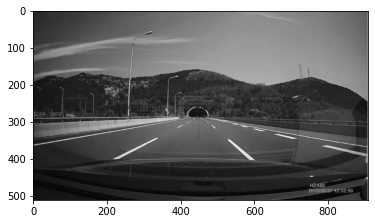

(512, 908)


In [6]:
# Squeeze the array into 2D space
im = np.squeeze(im)
plt.imshow(im, cmap='gray')
plt.show()
print(im.shape)

#Implementing image smoothing
rows = im.shape[0]
cols = im.shape[1]

#input any kernel size
kernel_shape_row = 7
kernel_shape_col = 7

kernel = np.ones((kernel_shape_row, kernel_shape_col))/(kernel_shape_row * kernel_shape_col)
mag_smooth = np.zeros((rows,cols))
print(kernel.shape)

#pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + kernel_shape_row - 1, cols + kernel_shape_col - 1))
index_1_row = (int) ((kernel_shape_row - 1)/2)
index_last_row = (int) (rows + ((kernel_shape_row - 1)/2))
index_1_col = (int) ((kernel_shape_col - 1)/2)
index_last_col = (int) (cols + ((kernel_shape_col - 1)/2))
padded_gray[index_1_row:index_last_row, index_1_col:index_last_col] = im
# print(padded_gray.shape)

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+kernel_shape_row, y:y+kernel_shape_col]).sum()     
        
# print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.show()

In [7]:
def increase_contrast(img):
    for x, row in enumerate(img):
        for y, col in enumerate(row):
            if img[x][y] >= 200:
                if img[x][y] < 235:
                    img[x][y] += 20
                else:
                    img[x][y] = 255
            if img[x][y] < 200:
                if img[x][y] >= 125 :
                    img[x][y] -= 125
                else:
                    img[x][y] = 0
                
    return img

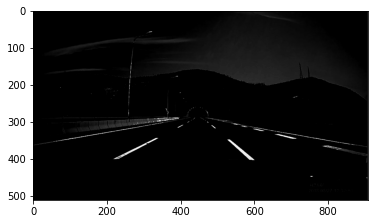

In [8]:
contrast_im = increase_contrast(im)
plt.imshow(contrast_im, cmap='gray')
plt.show()

(512, 908)


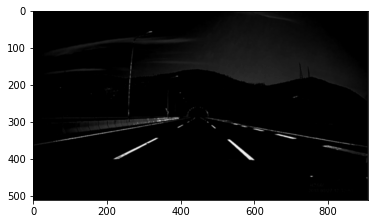

In [9]:
# Tharm's image smoothing
# Implementing image smoothing
rows = contrast_im.shape[0]
cols = contrast_im.shape[1]
print(im.shape)

kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
# print(kernel)
mag_smooth = np.zeros((rows,cols))

# pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + 2, cols + 2))
# print(img.shape)
padded_gray[1:-1, 1:-1] = contrast_im

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+3, y:y+3]).sum()     
        
# print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.show()

(512, 908)
finished making new image
(512, 908)


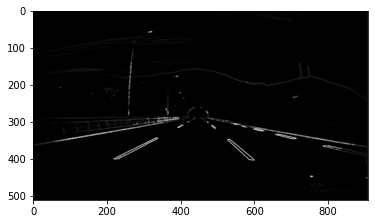

In [10]:
# Tharm's Sobel Edge Detector
## Implementing sobel edge detector
Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

mag_G = np.zeros((rows,cols))
#mag_G_thresh = np.zeros((rows,cols))
print(mag_G.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        sumx = (Gx * contrast_im[i-1:i+2, j-1:j+2]).sum()
        sumy = (Gy * contrast_im[i-1:i+2, j-1:j+2]).sum()
        mag_G[i][j] = np.sqrt(sumx**2 + sumy**2)
        
print('finished making new image')
print(mag_G.shape)
plt.imshow(mag_G, cmap='gray')
plt.show()

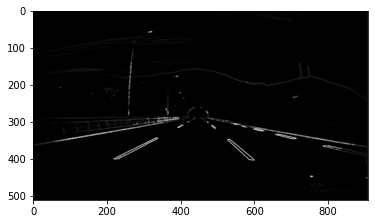

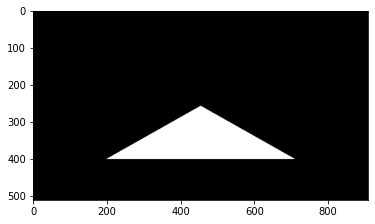

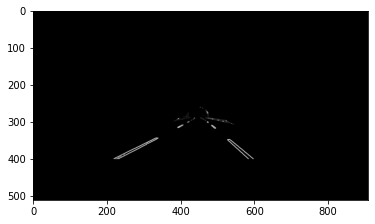

In [11]:
# Own implementation of cropped image
plt.imshow(mag_G, cmap='gray')
plt.show()
mask = np.zeros_like(mag_G)
mask = fillMask(mask)
plt.imshow(mask, cmap='gray')
plt.show()
cropped_im = apply_mask(mag_G, mask)
plt.imshow(cropped_im, cmap='gray')
plt.show()

1111


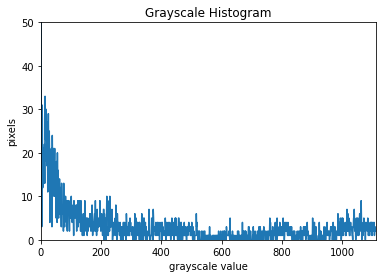

In [12]:
##Making histogram to find threshold

maxValue = int(np.amax(cropped_im)) + 1
print(maxValue)

histogram, bin_edges = np.histogram(cropped_im, bins=maxValue, range=(0,maxValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0, maxValue])
plt.ylim([0, 50]) # must be changed manually after generating once for better visual analysis

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

(512, 908)
thresholding done
(512, 908)


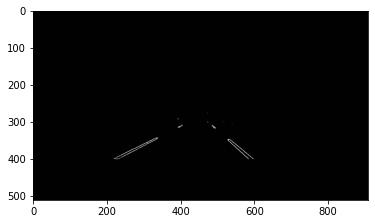

In [22]:
##Thresholding
threshold = 800 #since this is done using visual analysis of histogram, this needs work

threshImage = np.zeros((rows, cols))
print(threshImage.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if cropped_im[i][j] < threshold:
            threshImage[i][j] = 0
        else:
            threshImage[i][j] = 255

print('thresholding done')
print(threshImage.shape)
plt.imshow(threshImage, cmap = 'gray')
plt.show()

In [23]:
# Rohit's code
def Hough_lines(img, line_length):

    height, width = img.shape[:2]
    
    # Creates the accumulator space
    accumulator = np.zeros([180, int(math.sqrt(height ** 2 + width ** 2))])

    lines = np.array([[0, 0], [0, 0]])

    #line_length = 40

    # look for every pixel
    for y in range(0, height):
        for x in range(0, width):
            # if pixel is white (possible part of a line)
            if img[y][x] > 250:
                # try all angles
                # Step = 3 to decrease number of lines
                for theta in range(0, 180, 1):
                    p = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
                    accumulator[theta][p] += 1
                    # Check if it looks like line and if it's not in a list
                    if (accumulator[theta][p] > line_length) and (p not in lines[:, 0]) and (theta not in  lines[:, 1]):
                        # lines is an array of [rho, theta] pairs that has a lot of points in the accumulator space
                        lines = np.vstack((lines, np.array([p, theta])))

    # clean two first zeros
    lines = np.delete(lines, [0, 1], axis=0)
    
#     print(lines)

    return accumulator, lines

In [24]:
# Rohit's code
# Outputs 2 different points on the line to draw the line
def hough_intersect (rho, theta, image):
    h, w = image.shape[:2]
    out = []
    theta = math.radians(theta)
    intersect = [int(round(rho / math.sin(theta))), int(round((rho - w * math.cos(theta)) / math.sin(theta))), int(round(rho / math.cos(theta))),
                 int(round((rho - h * math.sin(theta)) / math.cos(theta)))]
    
    
    # Use formula to get 2 points in a line, one being 100 pixels from left and another being 100 pixels from right
    x1 = 100
    y1 = int(x1 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))
    
    x2 = 800
    y2 = int(x2 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))
    out.append((x1, y1))
    out.append((x2, y2))
    
    return out

In [30]:
hough_space, point_stack = Hough_lines(threshImage, 50)

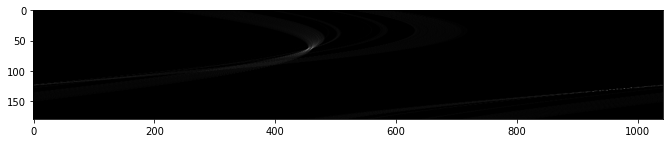

In [31]:
plt.figure(figsize = (20,2))
plt.imshow(hough_space, cmap='gray')
plt.show()

In [32]:
test = hough_intersect(443, 69, orig)

[((100, 456), (800, 114)), ((100, 452), (800, 125)), ((100, 460), (800, 104)), ((100, 470), (800, 97)), ((100, -2), (800, 564)), ((100, -35), (800, 595)), ((100, 10), (800, 557)), ((100, -15), (800, 572)), ((100, -50), (800, 602))]
[459, -18, 578, 110]
-0.49857142857142855 0.8514285714285714
508.85714285714283 -103.14285714285714
[453.33333333 282.83809524]


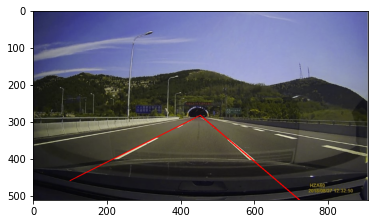

In [34]:
points_coord = [] #To store the coordinates of the lines
lines = []

for i in point_stack:
    points = hough_intersect(i[0], i[1], orig)
    if (len(points) > 1):
        points_coord.append([list(point) for point in points])
        lines.append((points[0], points[1]))

intersect = [0, 0, 0, 0]
intersect_count= [0, 0, 0, 0]

h, w = orig_img.shape[:2]

print(lines)

for line in lines:
    # Check which lane the line represents and add value to intersect to get total
    if line[0][1] > h/2:
        intersect[0] += line[0][1]
        intersect_count[0] += 1
    else:
        intersect[1] += line[0][1]
        intersect_count[1] += 1
    
    if line[1][1] > h/1:
        intersect[2] += line[1][1]
        intersect_count[2] += 1
    else:
        intersect[3] += line[1][1]
        intersect_count[3] += 1
        
# Divide total added values of each point by count to get average        
for i, total in enumerate(intersect):
    intersect[i] = int(total / intersect_count[i])

print(intersect)

# Calculate the 2 slopes
m1 = (intersect[3] - intersect[0]) / 700  # positive slope
m2 = (intersect[2] - intersect[1]) / 700  # negative slope

print(m1, m2)

# Calculate y intercept
c1 = intersect[0] - m1 * 100
c2 = intersect[1] - m2 * 100
print(c1, c2)

# Solve system of equations to get intersection point/vanishing point
A = np.array([[-m1, 1], [-m2, 1]])
B = np.array([c1, c2])
C = np.linalg.solve(A, B)
print(C)

# Draw 2 average lines for each lane with vanishing point
cv.line(orig_img, (100, intersect[0]), (int(C[0]), int(C[1])), (255,0,0), thickness=2)
cv.line(orig_img, (int(C[0]), int(C[1])), (800, intersect[2]), (255,0,0), thickness=2)
    
plt.imshow(orig_img)
plt.show()